ใน ep นี้ เราจะใช้ความรู้จาก [ep ก่อน ในการสร้าง Term-Document Matrix ด้วย CountVectorizer](https://www.bualabs.com/archives/2971/lsa-latent-semantic-analysis-text-classification-singular-value-decomposition-svd-non-negative-matrix-factorization-nmf-nlp-ep-4/) ด้วยข้อมูลรีวิวหนัง IMDB แล้วนำ Term-Document Matrix ที่ได้ มาวิเคราะห์ Sentiment Classification ว่าเป็นรีวิวแง่บวก หรือแง่ลบ (positive/negative) ด้วยเทคนิค Naive Bayes และ [Logistic Regression](https://www.bualabs.com/archives/1945/what-is-cross-entropy-loss-logistic-regression-log-loss-loss-function-ep-3/)

# 0. Install

Install Library ที่จำเป็น

In [1]:
## Colab
! curl -s https://course.fast.ai/setup/colab | bash


Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import

Import Library ที่จะใช้ ในที่นี้คือ fastai.text และ sklearn_text ที่ใช้ในงาน [NLP](https://www.bualabs.com/archives/119/what-is-nlp-natural-language-processing-nlp-task-in-thai-nlp-ep-1/)

In [0]:
from fastai import *
from fastai.text import *
import sklearn.feature_extraction.text as sklearn_text
from matplotlib import pyplot as plt
import seaborn as sns

# 2. Dataset

ในเคสนี้เราจะใช้ IMDB Movie Review เป็นรีวิวหนังจากเว็บ IMDB ที่มีข้อความ และ คะแนนว่าเป็นแง่บวก หรือแง่ลบ

ในการพัฒนา เราจะใช้ Dataset ชุดเล็กก่อน จะได้เร็ว เมื่อเทสทุกอย่างเรียบร้อย แล้วจึงขยับไปใช้ Dataset ชุดเต็ม 

In [4]:
path = untar_data(URLs.IMDB_SAMPLE)
path

PosixPath('/root/.fastai/data/imdb_sample')

ดูว่ามีไฟล์อะไรบ้าง

In [5]:
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv')]

โหลดไฟล์ csv ขึ้นมา ใส่ Pandas Dataframe

In [6]:
df = pd.read_csv(path/'texts.csv')
df.shape

(1000, 3)

มีข้อมูลตัวอย่าง 1000 Record, 3 Column ดูตัวอย่างข้อมูล 5 Record แรก

In [7]:
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


# 3. Preprocessing

เราจะใช้ Fastai TextList ในการ Preprocess ข้อมูล เช่น Tokenization, Numberization, etc.

In [0]:
movie_reviews = (TextList.from_csv(path, 'texts.csv', cols='text').split_from_df(col=2).label_from_df(cols=0))

จะได้ [Trainint Set, Validation Set](https://www.bualabs.com/archives/532/what-is-training-set-why-train-test-split-training-set-validation-set-test-set/) ออกมา เรามาดูข้อมูลตัวอย่าง Record แรกใน Validation Set 

In [9]:
movie_reviews.valid.y[0], movie_reviews.valid.x[0]

(Category positive,
 Text xxbos xxmaj this very funny xxmaj british comedy shows what might happen if a section of xxmaj london , in this case xxmaj xxunk , were to xxunk itself independent from the rest of the xxup uk and its laws , xxunk & post - war xxunk . xxmaj merry xxunk is what would happen . 
  
   xxmaj the explosion of a wartime bomb leads to the xxunk of ancient xxunk which show that xxmaj xxunk was xxunk to the xxmaj xxunk of xxmaj xxunk xxunk ago , a small historical xxunk long since forgotten . xxmaj to the new xxmaj xxunk , however , this is an unexpected opportunity to live as they please , free from any xxunk from xxmaj xxunk . 
  
   xxmaj stanley xxmaj xxunk is excellent as the minor city xxunk who suddenly finds himself leading one of the world 's xxunk xxunk . xxmaj xxunk xxmaj margaret xxmaj xxunk is a delight as the history professor who sides with xxmaj xxunk . xxmaj others in the stand - out cast include xxmaj xxunk xxmaj xxunk , xxmaj paul xxmaj xxunk , xxmaj

จะเห็น Label y ว่าเป็น รีวิวแง่บวก Positive และ Text x เป็นข้อความรีวิว

ดูขนาดของ Training Set และ Validation Set

In [10]:
len(movie_reviews.train.x), len(movie_reviews.valid.x)

(800, 200)

ขนาดของ vocab Dictionary ที่ Map จาก เลขลำดับ Token ไปเป็น ข้อความ และ ข้อความ เป็น เลขลำดับ Token 

จะเห็นว่า ไม่ตรงกัน stoi มากกว่า itos เนื่องจากมีหลาย ๆ คำ ถูก Map ไปเป็น Unknown เพื่อจำกัดจำนวน vocab

In [11]:
len(movie_reviews.vocab.itos), len(movie_reviews.vocab.stoi)

(6008, 19161)

ดูตัวอย่างคำว่า love เป็น คำลำดับที่ 142 ใน vocab

In [12]:
movie_reviews.vocab.stoi['love']

142

ดูคำที่ 142 ใน vocab itos เป็นคำว่า love จริง ๆ

In [13]:
movie_reviews.vocab.itos[142]

'love'

ดู vocab ในช่วงคำว่า love

In [14]:
movie_reviews.vocab.itos[140:149]

['life', 'characters', 'love', 'your', 'here', 'know', 'scenes', 'best', 'end']

ดู vocab 20 คำท้ายสุด

In [15]:
movie_reviews.vocab.itos[-20:]

['uncritical',
 'whack',
 'heavies',
 'poe',
 'monstervision',
 'penn',
 'shrine',
 'lupino',
 'pegg',
 'grasshoppers',
 'flik',
 'ladder',
 'wtc',
 'portuguese',
 'della',
 'contractor',
 'coaxes',
 'mabuse',
 'greyson',
 'sollett']

ดู vocab 20 คำแรก คำแรก ๆ จะเป็น Reserved Token รายละเอียดดังนี้ [Sentiment Analysis ep.1 / Tokenization](https://www.bualabs.com/archives/926/sentiment-analysis-imdb-movie-review-ulmfit-sentiment-analysis-ep-1/#Tokenization)





In [16]:
movie_reviews.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 '.',
 ',',
 'and',
 'a',
 'of',
 'to',
 'is',
 'it',
 'in',
 'i']

ดูตัวอย่าง vocab Dictionary ที่ได้ โดยแสดง Text และ เลขลำดับ คู่กัน

In [17]:
from itertools import *
list(islice(movie_reviews.vocab.stoi.items(), 20))

[('xxunk', 0),
 ('xxpad', 1),
 ('xxbos', 2),
 ('xxeos', 3),
 ('xxfld', 4),
 ('xxmaj', 5),
 ('xxup', 6),
 ('xxrep', 7),
 ('xxwrep', 8),
 ('the', 9),
 ('.', 10),
 (',', 11),
 ('and', 12),
 ('a', 13),
 ('of', 14),
 ('to', 15),
 ('is', 16),
 ('it', 17),
 ('in', 18),
 ('i', 19)]

คำที่อยู่นอก vocab Dictionary จะถูก Map เป็น Unknown (xxunk)

In [18]:
i = movie_reviews.vocab.stoi['bualabs']
movie_reviews.vocab.itos[i], i

('xxunk', 0)

In [19]:
i = movie_reviews.vocab.stoi['suvarnabhumi']
movie_reviews.vocab.itos[i], i

('xxunk', 0)

In [20]:
i = movie_reviews.vocab.stoi['airport']
movie_reviews.vocab.itos[i], i

('airport', 4978)

เลือก x ของ Record แรก ของ Training Set ดูข้อความ

In [21]:
t = movie_reviews.train[0][0]
t

Text xxbos xxmaj un - xxunk - believable ! xxmaj meg xxmaj ryan does n't even look her usual xxunk lovable self in this , which normally makes me forgive her shallow xxunk acting xxunk . xxmaj hard to believe she was the producer on this dog . xxmaj plus xxmaj kevin xxmaj kline : what kind of suicide trip has his career been on ? xxmaj xxunk ... xxmaj xxunk ! ! ! xxmaj finally this was directed by the guy who did xxmaj big xxmaj xxunk ? xxmaj must be a replay of xxmaj jonestown - hollywood style . xxmaj xxunk !

ภายใน x จะถูก Tokenize, Numberize แปลงเป็นตัวเลขเรียบร้อยแล้ว

In [22]:
t.data[:30]

array([   2,    5, 4619,   25,    0,   25,  867,   52,    5, 3776,    5, 1800,   95,   37,   85,  191,   64,  935,
          0, 2738,  517,   18,   21,   11,   84, 2417,  192,   88, 3777,   64])

# 4. Creating Term-Document Matrix

นำข้อมูลจากด้านบน มาสร้าง Term-Document Matrix

## 4.1 Counter

ตัวอย่างการใช้งาน Counter class

In [23]:
c = Counter([1, 2, 3, 4, 5, 
             1, 2, 3, 4, 
             1, 2, 3, 
             1, 2, 
             1])
c

Counter({1: 5, 2: 4, 3: 3, 4: 2, 5: 1})

จะนับครั้งที่ข้อมูลปรากฎ มาใส่ใน Dictionary

In [24]:
c.keys(), c.values()

(dict_keys([1, 2, 3, 4, 5]), dict_values([5, 4, 3, 2, 1]))

## 4.2 Term-Document Matrix as Sparse Matrix

เนื่องจาก ใน 1 รีวิว ไม่ได้ยาวมาก ไม่ได้มีคำหลากหลาย แต่ 1 รีวิวใช้เพียง 100 กว่าคำ จาก vocab 6000 กว่าคำ ทำให้ Term-Document Matrix นี้ส่วนใหญ่มีค่าเป็น 0 เรียกว่า [Sparse Matrix](https://www.bualabs.com/archives/tag/sparse-matrix/) จะอธิบายต่อไป

In [25]:
c = Counter(movie_reviews.valid.x[0].data)
len(c), c

(95,
 Counter({0: 32,
          2: 1,
          5: 32,
          6: 1,
          9: 10,
          10: 7,
          11: 10,
          12: 1,
          13: 4,
          14: 6,
          15: 6,
          16: 4,
          18: 2,
          20: 1,
          21: 3,
          23: 1,
          24: 3,
          25: 2,
          26: 1,
          27: 3,
          30: 1,
          44: 1,
          45: 1,
          49: 1,
          50: 3,
          52: 1,
          54: 2,
          58: 1,
          59: 1,
          63: 2,
          71: 1,
          74: 1,
          77: 1,
          84: 1,
          109: 1,
          115: 1,
          149: 1,
          189: 1,
          194: 1,
          197: 2,
          204: 1,
          207: 1,
          221: 1,
          239: 1,
          251: 1,
          258: 1,
          285: 1,
          288: 1,
          319: 1,
          324: 1,
          337: 1,
          358: 1,
          378: 1,
          404: 1,
          409: 1,
          430: 1,
          456: 1,
    

จากด้านบน ดู Token ที่ปรากฎหลาย ๆ ครั้ง ปรากฎว่าเป็น Token พิเศษ Unknow, Begin of sentense, ตัว Capital, ตัวใหญ่ และ คำว่า The

In [26]:
idx = [0, 2, 5, 6, 9]
[movie_reviews.vocab.itos[i] for i in idx]

['xxunk', 'xxbos', 'xxmaj', 'xxup', 'the']

ดูตัวอย่างข้อมูล Record แรก ใน Validation Set 

In [27]:
movie_reviews.valid.y[1], movie_reviews.valid.x[1]

(Category positive,
 Text xxbos i saw this movie once as a kid on the late - late show and fell in love with it . 
  
   xxmaj it took 30 + years , but i recently did find it on xxup dvd - it was n't cheap , either - in a xxunk that xxunk in war movies . xxmaj we watched it last night for the first time . xxmaj the audio was good , however it was grainy and had the trailers between xxunk . xxmaj even so , it was better than i remembered it . i was also impressed at how true it was to the play . 
  
   xxmaj the xxunk is around here xxunk . xxmaj if you 're xxunk in finding it , fire me a xxunk and i 'll see if i can get you the xxunk . xxunk)

ดู label และ ข้อมล ที่แปลงเป็น ตัวเลข แล้ว ทั้งหมด

In [28]:
movie_reviews.valid.y[1].data, movie_reviews.valid.x[1].data

(1, array([  2,  19, 248,  21, ...,   9,   0,  10,   0]))

ประกาศฟังก์ชัน สร้าง Term-Document Matrix โดย output เป็น Sparse Matrix แบบ Compressed sparse row (CSR, CRS หรือ Yale format)

In [0]:
def get_term_doc_matrix(label_list, vocab_len):
    j_indices = []
    indptr = []
    values = []
    indptr.append(0)

    for i, doc in enumerate(label_list):
        feature_counter = Counter(doc.data)
        j_indices.extend(feature_counter.keys())
        values.extend(feature_counter.values())
        indptr.append(len(j_indices))

    # return (values, j_indices, indptr)

    return scipy.sparse.csr_matrix((values, j_indices, indptr), 
                                   shape=(len(indptr)-1, vocab_len), 
                                   dtype=int)

จับเวลาการสร้าง Term-Document Matrix ด้วยข้อมูล Validation Set

In [30]:
%%time
val_term_doc = get_term_doc_matrix(movie_reviews.valid.x, len(movie_reviews.vocab.itos))

CPU times: user 46.4 ms, sys: 2.66 ms, total: 49.1 ms
Wall time: 50.4 ms


จับเวลาการสร้าง Term-Document Matrix ด้วยข้อมูล Training Set

In [31]:
%%time
trn_term_doc = get_term_doc_matrix(movie_reviews.train.x, len(movie_reviews.vocab.itos))

CPU times: user 221 ms, sys: 15.5 ms, total: 236 ms
Wall time: 215 ms


ได้ output ออกมา จำนวน column เท่ากับ ขนาด vocab Dictionary

In [32]:
trn_term_doc.shape

(800, 6008)

In [33]:
val_term_doc.shape

(200, 6008)

## 4.3 Sparse Matrix vs Dense Matrix

Sparse จะถูกจัดเก็บด้วยวิธีเฉพาะ เพื่อประหยัดเนื้อที่ ทำให้บางทีเราไม่สามารถเรียกดูข้อมูลตรง ๆ ได้

In [34]:
trn_term_doc[:, -10:]

<800x10 sparse matrix of type '<class 'numpy.int64'>'
	with 10 stored elements in Compressed Sparse Row format>

เราต้องเรียน todense เพื่อแปลงเป็น Matrix ปกติก่อน

In [35]:
trn_term_doc.todense()[:8, :8]

matrix([[ 8,  0,  1,  0,  0, 15,  0,  0],
        [22,  0,  1,  0,  0, 33,  2,  0],
        [ 4,  0,  1,  0,  0, 16,  2,  0],
        [13,  0,  1,  0,  0, 11,  0,  0],
        [12,  0,  1,  0,  0, 21,  0,  0],
        [ 4,  0,  1,  0,  0, 12,  1,  0],
        [ 4,  0,  1,  0,  0, 15,  0,  0],
        [42,  0,  1,  0,  0, 43, 14,  0]])

นำส่วนหนึ่งมาพล็อต Heatmap ดู จะเห็นว่า Sparse มาก ๆ ดำหมด ไม่เห็นอะไรเลย เป็น 0 เกือบหมด

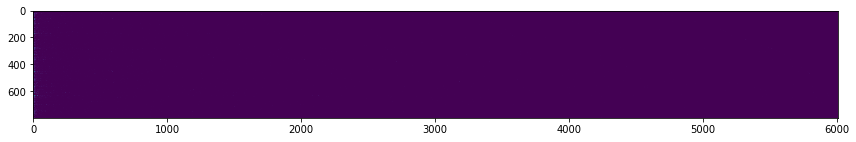

In [36]:
fig, ax = plt.subplots(figsize=(12, 2))
ax.imshow(trn_term_doc.todense(), interpolation='nearest')
plt.tight_layout()

ซูมดู 100 Feature แรก ของ 100 ข้อมูลตัวอย่างแรก

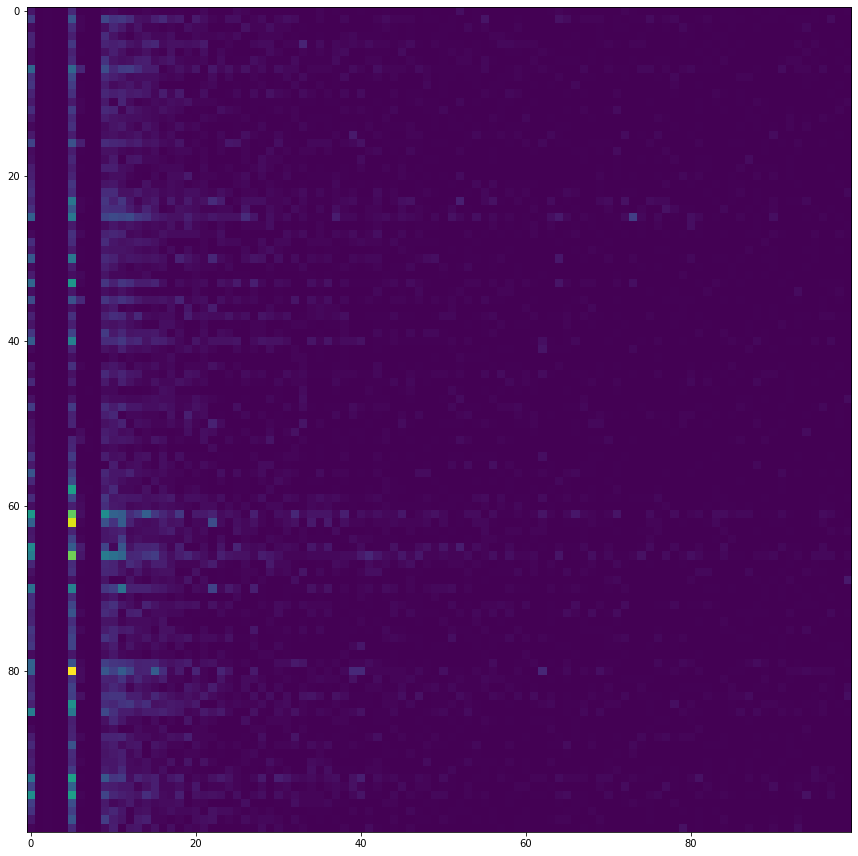

In [37]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(trn_term_doc.todense()[:100, :100], interpolation='nearest')
plt.tight_layout()

## 4.4 Data Exploration

เราจะมา สำรวจข้อมูล ทำ Data Exploration กันต่อ

In [0]:
v = movie_reviews.vocab

ดู Token แรกใน vocab

In [39]:
v.itos[0]

'xxunk'

ดู Token สุดท้ายใน vocab

In [40]:
v.itos[-1:]

['sollett']

ดู Token ที่ 4 ใน vocab

In [41]:
v.itos[3]

'xxeos'

เราจะมาดูตัวอย่างข้อความ Record ที่ 1 ใน Validation Set มีคำว่า Late 2 คำ ในข้อความ

In [42]:
review = movie_reviews.valid.x[1]; review

Text xxbos i saw this movie once as a kid on the late - late show and fell in love with it . 
 
  xxmaj it took 30 + years , but i recently did find it on xxup dvd - it was n't cheap , either - in a xxunk that xxunk in war movies . xxmaj we watched it last night for the first time . xxmaj the audio was good , however it was grainy and had the trailers between xxunk . xxmaj even so , it was better than i remembered it . i was also impressed at how true it was to the play . 
 
  xxmaj the xxunk is around here xxunk . xxmaj if you 're xxunk in finding it , fire me a xxunk and i 'll see if i can get you the xxunk . xxunk

คำว่า Late คือคำที่ 451 ใน vocab Dictionary

In [43]:
i = v.stoi['late']; i

451

ดูใน Validation Term-Document Matrix ที่ Row 1, Column 451 จะได้ 2

In [44]:
val_term_doc[1, 451]

2

ข้อความ Record ที่ 1 ใน Validation Set มีทั้งหมด 144 Token จาก 81 คำศัพท์

In [45]:
val_term_doc[1].sum(), (val_term_doc[1] > 0).sum()

(144, 81)

Token ที่ Numberize แล้ว

In [46]:
review.data

array([  2,  19, 248,  21, ...,   9,   0,  10,   0])

แปลง Token ที่ Numberize แล้ว กลับเป็น Token ข้อความ

In [47]:
[v.itos[i] for i in review.data][:20]

['xxbos',
 'i',
 'saw',
 'this',
 'movie',
 'once',
 'as',
 'a',
 'kid',
 'on',
 'the',
 'late',
 '-',
 'late',
 'show',
 'and',
 'fell',
 'in',
 'love',
 'with']

## 4.5 Unknown Words

จำนวน itos ไม่เท่ากับ stoi เนื่องจาก หลายคำที่ปรากฎไม่บ่อย กลายเป็น Unknown เพื่อจำกัดขนาด vocab Dictionary

In [48]:
len(v.itos), len(v.stoi)

(6008, 19163)

ต่างกันถึง 13155 คำ

In [49]:
len(v.stoi) - len(v.itos)

13155

ดูรายการ Unknown Word ทั้งหมด

In [50]:
unk = [k for k, v in v.stoi.items() if v == 0]
len(unk), unk[:20]

(13156,
 ['xxunk',
  'bleeping',
  'pert',
  'ticky',
  'schtick',
  'whoosh',
  'banzai',
  'chill',
  'wooofff',
  'cheery',
  'superstars',
  'fashionable',
  'cruelly',
  'separating',
  'mistreat',
  'tensions',
  'religions',
  'baseness',
  'nobility',
  'puro'])

# 5. Sentiment Classification

เราจะใช้ Term-Document Matrix ที่ได้จากด้านบน มาวิเคราะห์ความรู้สึก Sentiment Classification ว่ารีวินี้ เป็นแง่บวก หรือแง่ลบ ด้วยอัลกอริทึมต่าง ๆ 

## 5.1 Naive Bayes


กำหนดสัดส่วน log-count ratio $r$ สำหรับแต่ละคำ $f$:

$r = \log \frac{\text{ratio of feature $f$ in positive documents}}{\text{ratio of feature $f$ in negative documents}}$

โดยสัดส่วนของฟีเจอร์ $f$ ในรีวิวแง่บวก คือ จำนวนครั้งที่รีวิวแง่บวกมีฟีเจอร์นี้ หารด้วยจำนวนรีวิวแง่บวกทั้งหมด


แสดง class ของ รีวิวหนัง

In [51]:
movie_reviews.y.classes

['negative', 'positive']

กำหนด x, y ของ Training Set และ val_y ของ Validation Set

In [0]:
x = trn_term_doc
y = movie_reviews.train.y
val_y = movie_reviews.valid.y

แปลง class กลับเป็นเลข 1 แทน positive, 0 แทน negative

In [53]:
positive = y.c2i['positive']
negative = y.c2i['negative']

positive, negative

(1, 0)

เลือกเฉพาะ รีวิวที่ negative มา Sum ในมิติ 0 ให้ได้ จำนวน Count รวมแต่ละ Feature

In [54]:
np.squeeze(np.asarray(x[y.items==negative].sum(0)))

array([7154,    0,  417,    0, ...,    0,    3,    3,    3], dtype=int64)

เลือกเฉพาะ รีวิวที่ positive มา Sum ในมิติ 0 ให้ได้ จำนวน Count รวมแต่ละ Feature

In [55]:
np.squeeze(np.asarray(x[y.items==positive].sum(0)))

array([6471,    0,  383,    0, ...,    3,    0,    0,    0], dtype=int64)

### จำนวน Count รวมแต่ละ Feature แยก Positive, Negative

In [56]:
p1 = np.squeeze(np.asarray(x[y.items==positive].sum(0)))
p0 = np.squeeze(np.asarray(x[y.items==negative].sum(0)))

len(p1), len(p0)

(6008, 6008)

แสดง จำนวน Count ของ 10 คำศัพท์แรก ใน positive, negative

In [57]:
p1[:10], p0[:10]

(array([ 6471,     0,   383,     0,     0, 10267,   674,    57,     0,  5260], dtype=int64),
 array([ 7154,     0,   417,     0,     0, 10741,   908,    53,     1,  6150], dtype=int64))

### Explore Ratio

ประกาศฟังก์ชัน หาสัดส่วน Ratio ของ Count positive/negative คำที่กำหนด

In [0]:
def p_ratio(s):
    i = v.stoi[s]
    return p1[i]/p0[i]

loved มี ratio มากกว่า 1 ไปเยอะเลย

In [59]:
s = 'loved'
p_ratio(s)

2.4166666666666665

hated ratio = 0.5 น้อยกว่า 1 แสดงว่า ปรากฎใน negative รีวิวมากกว่า 2 เท่า

In [60]:
s = 'hated'
p_ratio(s)

0.5

best ก็มากกว่า 1

In [61]:
s = 'best'
p_ratio(s)

1.369047619047619

worst ยิ่งชัดมาก ปรากฎใน negative รีวิว บ่อยกว่า positive มาก ๆ

In [62]:
s = 'worst'
p_ratio(s)

0.05333333333333334

### Explore data

ดู Positive รีวิว ที่มีคำว่า hated

In [63]:
v.stoi['hated']

1977

หา record ที่มี count คำที่ 1977 มากกว่า 0

In [64]:
a = np.argwhere((x[:, 1977] > 0))[:, 0]; a

array([ 15,  49, 304, 351, 393, 612, 695, 773], dtype=int32)

หาเฉพาะ record ที่เป็น positive

In [65]:
b = np.argwhere(y.items==positive)[:, 0]; b

array([  1,   3,  10,  11, ..., 787, 789, 790, 797])

นำมา intersect กัน

In [66]:
set(a).intersection(set(b))

{393, 612, 695}

ไล่ดูข้อความรีวิว ทั้ง 3 record

In [67]:
review = movie_reviews.train.x[393]
review.text

'xxbos xxmaj there are numerous films relating to xxup xxunk , but xxmaj mother xxmaj night is quite xxunk among them : xxmaj in this film , we are introduced to xxmaj howard xxmaj campbell ( xxmaj nolte ) , an xxmaj american living in xxmaj berlin and married to a xxmaj german , xxmaj xxunk xxmaj xxunk ( xxmaj lee ) , who decides to accept the role of a spy : xxmaj more specifically , a xxup cia agent xxmaj major xxmaj xxunk ( xxmaj goodman ) recruits xxmaj campbell who becomes a xxmaj nazi xxunk in order to enter the highest xxunk of the xxmaj hitler xxunk . xxmaj however , the deal is that the xxup us xxmaj government will never xxunk xxmaj campbell \'s role in the war for national security reasons , and so xxmaj campbell becomes a hated figure across the xxup us . xxmaj after the war , he tries to xxunk his identity , but the past comes back and xxunk him . xxmaj his only " friend " is xxmaj xxunk , but even he can not do much for the xxunk of events that fall upon poor xxmaj campb

In [68]:
review = movie_reviews.train.x[612]
review.text

'xxbos xxmaj once upon a time in a castle xxrep 6 . xxmaj two little girls are playing in the garden \'s castle . xxmaj they are sisters . a blonde little girl ( xxmaj kitty ) and a brunette one ( xxmaj evelyn ) . xxmaj evelyn steals xxmaj kitty \'s doll . xxmaj kitty xxunk xxmaj evelyn . xxmaj running through long xxunk , they reach the room where their grandfather , sitting on an xxunk , reads the newspaper . xxmaj kitty xxunk about xxmaj evelyn , while xxmaj evelyn is looking xxunk at a picture hanging on the wall . xxmaj evelyn begins to say repeatedly : " i am the red lady and xxmaj kitty is the black lady " . xxmaj suddenly xxmaj evelyn grabs a dagger lying nearby and stabs xxmaj kitty \'s doll and then cuts her ( the doll \'s ) head . a fight ensues . xxmaj and xxmaj evelyn almost uses the dagger against xxmaj kitty . xxmaj the grandfather xxunk and the worst is avoided . \n \n  xxmaj later on , their grandfather tells them the legend related to the picture hanging on the wall i

In [69]:
review = movie_reviews.train.x[695]
review.text

"xxbos xxmaj xxunk , yeah this episode is extremely underrated . \n \n  xxmaj even though there is a xxup lot of bad writing and acting at parts . i think the good over wins the bad . \n \n  i love the xxunk parts and the big ' twist ' at the end . i absolutely love that scene when xxmaj michelle xxunk xxmaj tony . xxmaj it 's actually one of my favorite scenes of xxmaj season 1 . \n \n  xxmaj for some reason , people have always hated the xxmaj xxunk episodes , yet i have always liked them . xxmaj they 're not the best , in terms of writing . but the theme really does interest me , \n \n  i 'm gon na give it a xxup three star , but if the writing were a little more consistent i 'd give it xxup four ."

กลับกัน ดู Negative รีวิว ที่มีคำว่า loved

In [70]:
v.stoi['loved']

535

หา record ที่มี count คำที่ 535 มากกว่า 0

In [71]:
a = np.argwhere((x[:, 535] > 0))[:, 0]; a

array([  1,  15,  29,  69,  75,  79, 174, 185, 200, 205, 262, 296, 303, 333, 350, 351, 398, 407, 440, 489, 496, 528,
       538, 600, 602, 605, 627, 642, 657, 660, 700, 712, 729, 735, 755, 767, 785], dtype=int32)

In [72]:
b = np.argwhere(y.items==negative)[:, 0]; b

array([  0,   2,   4,   5, ..., 795, 796, 798, 799])

In [73]:
set(a).intersection(set(b))

{15, 200, 205, 303, 351, 398, 600, 605, 642, 700, 729, 767}

ไล่ดูข้อความรีวิว 3 record แรก

In [74]:
review = movie_reviews.train.x[15]
review.text

"xxbos xxmaj as if the storyline was n't depressing enough , this movie shows xxunk being xxunk graphically in a slaughterhouse for all of five minutes while the protagonist is xxunk her early life as a butcher . xxmaj weird stuff . xxmaj then there 's the core premise of the hero / heroine who goes and cuts his dick off because a he 's xxunk - ten with at work says he would have gone with him if he was a girl . xxmaj is this person a psycho , a xxunk , just a doomed queen who takes things too far ? xxmaj and what sort of xxunk childhood did he have ? xxmaj just that he did n't get adopted and had to live it out with xxunk who at first loved him and then later hated him because he was xxunk . xxmaj he tries to explain to us the reasons he did what he did , but it 's really really so hard to xxunk . xxmaj such sad and unusual self destruction . xxmaj was it supposed to be funny ? xxmaj what was it all about really ?"

In [75]:
review = movie_reviews.train.x[200]
review.text

'xxbos i loved the first " xxmaj azumi " movie . i \'ve seen xxmaj ms. xxmaj ueto in a variety of her xxup tv appearances and i \'ve seen my fair share of samurai and ninja flicks . i have to say that this movie was much weaker than i \'d expected . \n \n  xxmaj given the movie \'s cast and set up in " xxmaj azumi " , they should have been able to do a much better job with this movie , but instead it was slow , xxunk in parts , and xxunk with very poor , unconvincing , and wooden acting . \n \n  xxmaj when they bothered to reference the first movie , they did so in a manner that was pretty loose and weak . xxmaj in " xxmaj azumi " , the title character is the best of a group of superior killers . xxmaj in " xxmaj azumi 2 " she seems somehow xxunk and less - impressive . \n \n  xxmaj that \'s not to say it was a total loss . xxmaj there were a few decent fight scenes and some over - the - top characters . xxmaj unfortunately , the movie suffers overall from the simple fact that xxmaj xx

In [76]:
review = movie_reviews.train.x[205]
review.text

'xxbos xxunk is normally xxunk , and it \'s never really bothered me before -- i loved " xxunk 2 " , but i really do n\'t like pseudo xxunk or playing on xxunk . the whole movie is based on a man with esp caused by an xxunk accident and a witch . i \'m not opposed to xxunk , and i liked " carrie " ( the novel and the movie ) but this one bothered me . i think it \'s because of the main character developing esp from an electric line . also the university professor wasting his time studying esp cases . i was n\'t alive in the 60s to know first hand whether or not esp was a common xxunk then , but i assume that any theory of such nature would simply be xxunk . what really bothered me was the way the police were xxunk xxunk as xxunk , xxunk villains who can seem like normal people 99 % of the time and then just snap . nothing could be further from the truth . i xxunk such xxunk because they add to public xxunk . many people still think that xxunk is xxunk identity xxunk . whoever wrote thi

### เข้าสูตร Naive Bayes

นำสูตรข้างบนมาคำนวนให้ดูอีกครั้งหนึ่งชัด ๆ 

In [77]:
p1 = np.squeeze(np.asarray(x[y.items==positive].sum(0)))
p0 = np.squeeze(np.asarray(x[y.items==negative].sum(0)))

len(p1), len(p0)

(6008, 6008)

บวก 1 เพื่อ Numerical Stability เช่น ป้องกัน Devide by zero

In [78]:
pr1 = (p1 + 1) / ((y.items==positive).sum() + 1)
pr0 = (p0 + 1) / ((y.items==negative).sum() + 1)

len(pr1), len(pr0)

(6008, 6008)

เนื่องจาก Ratio ถ้าเป็นคำศัพท์ค่อนข้าง positive จะมีค่า ratio 1-Infinity แต่ถ้าเป็นคำศัพท์ค่อนข้าง negative จะมี ratio 0-1 การใช้ log function จะช่วยปรับให้เป็นช่วง -Infinity-0, 0-Infinity เท่า ๆ กัน นำไปเปรียบเทียบ ใช้งานต่อได้ง่ายขึ้น

In [79]:
r = np.log(pr1/pr0); r

array([-0.015487,  0.084839,  0.      ,  0.084839, ...,  1.471133, -1.301455, -1.301455, -1.301455])

ดูคำศัพท์ที่มักถูกใช้ใน Positive / Negative Review

In [0]:
biggest = np.argpartition(r, -10)[-10:]
smallest = np.argpartition(r, 10)[:10]

คำที่ Positive ที่สุด

เนื่องจากเป็น Dataset ชุดเล็ก ข้อมูลน้อย อาจจะบอกอะไรไม่ได้มาก คำศัพท์บางคำอาจจะพบแค่ครั้งเดียว ในรีวิวแง่บวก positive ทำให้ความหมายผิดไป

In [81]:
[v.itos[i] for i in biggest]

['sport',
 'davies',
 'gilliam',
 'fanfan',
 'biko',
 'felix',
 'noir',
 'jabba',
 'astaire',
 'jimmy']

In [82]:
np.argmax(trn_term_doc[:, v.stoi['biko']])

515

In [83]:
movie_reviews.train.x[515]

Text xxbos " xxmaj the xxmaj true xxmaj story xxmaj of xxmaj the xxmaj friendship xxmaj that xxmaj shook xxmaj south xxmaj africa xxmaj and xxmaj xxunk xxmaj the xxmaj world . " 
 
  xxmaj richard xxmaj attenborough , who directed " a xxmaj bridge xxmaj too xxmaj far " and " xxmaj gandhi " , wanted to bring the story of xxmaj steve xxmaj biko to life , and the journey and trouble that xxunk xxmaj donald xxmaj woods went through in order to get his story told . xxmaj the films uses xxmaj wood 's two books for it 's information and basis - " xxmaj biko " and " xxmaj asking for xxmaj trouble " . 
 
  xxmaj the film takes place in the late 1970 's , in xxmaj south xxmaj africa . xxmaj south xxmaj africa is in the grip of the terrible apartheid , which keeps the blacks separated from the whites and xxunk the whites as the superior race . xxmaj the blacks are forced to live in xxunk on the xxunk of the cities and xxunk , and they come under frequent xxunk by the police and the army . xxmaj w

คำที่ Negative ที่สุด

In [84]:
[v.itos[i] for i in smallest]

['worst',
 'crap',
 'crater',
 'porn',
 'disappointment',
 'dog',
 'vargas',
 'naschy',
 'fuqua',
 'soderbergh']

In [85]:
np.argmax(trn_term_doc[:, v.stoi['soderbergh']])

434

In [86]:
movie_reviews.train.x[434]

Text xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of " xxmaj at xxmaj the xxmaj movies " in taking xxmaj steven xxmaj soderbergh to task . 
 
  xxmaj it 's usually satisfying to watch a film director change his style / subject , but xxmaj soderbergh 's most recent stinker , xxmaj the xxmaj girlfriend xxmaj xxunk ) , was also missing a story , so narrative ( and editing ? ) seem to suddenly be xxmaj soderbergh 's main challenge . xxmaj strange , after xxunk years in the business . xxmaj he was probably never much good at narrative , just xxunk it well inside " edgy " projects . 
 
  xxmaj none of this excuses him this present , almost diabolical failure . xxmaj as xxmaj david xxmaj xxunk xxunk , " two parts of xxmaj che do n't ( even ) make a whole " . 
 
  xxmaj epic xxunk in name only , xxmaj che(2008 ) barely qualifies as a feature film 

### Predict with Bayes

หาค่าเฉลี่ย จำนวนข้อมูลรีวิว แง่บวก แง่ลบ

In [87]:
(y.items==positive).mean(), (y.items==negative).mean()

(0.47875, 0.52125)

หาค่า bias ของข้อมูล เตรียมเอาไว้ บวกในสมการ เส้นตรง

In [88]:
b = np.log((y.items==positive).mean() / (y.items==negative).mean()) ; b

-0.08505123261815539

นำ Validation Term-Document Matrix มาคูณกับ r และ บวก b ดูว่าอันไหนมากกว่า 0 เป็น positive น้อยกว่า 0 เป็น netative

In [0]:
preds = (val_term_doc @ r + b ) > 0

เทียบกับ y ใน Validation Set ถูกต้องถึง 64.5% 

In [90]:
(preds == val_y.items).mean()

0.645

# 2/2. Full Dataset 

เมื่อทุกอย่างพร้อมแล้ว เราจะขยับไป Dataset ตัวเต็มกันต่อ

In [91]:
path = untar_data(URLs.IMDB)
path

PosixPath('/root/.fastai/data/imdb')

จะมี Folder ชื่อ train และ test

In [92]:
path.ls()

[PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/test'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas')]

ใน train จะมี Folder แยกตาม label pos/neg (Positive/Negative)

In [93]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/pos'),
 PosixPath('/root/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/neg')]

# 3/2. Preprocessing

ใช้ Fastai ทำ Preprocessing สร้าง TextList จากไฟล์ใน Folder ที่กำหนด Split ตาม Folder test ที่กำหนด แล้ว Label ตาม Folder neg/pos

In [0]:
reviews_full = (TextList.from_folder(path)
                    .split_by_folder(valid='test')
                    .label_from_folder(classes=['neg', 'pos']))

จะได้ [Training Set และ Validation Set](https://www.bualabs.com/archives/532/what-is-training-set-why-train-test-split-training-set-validation-set-test-set/) อย่างละ 25,000 ตัวอย่าง

In [95]:
len(reviews_full.train), len(reviews_full.valid)

(25000, 25000)

ดูจำนวนคำศัพท์ใน vocab Dictionary

In [96]:
v = reviews_full.vocab
len(v.itos), len(v.stoi)

(38456, 118460)

ดูตัวอย่างคำศัพท์ ใน vocab Dictionary

In [97]:
v.itos[100:110]

['bad',
 'people',
 'will',
 'other',
 'also',
 'into',
 'first',
 'because',
 'great',
 'how']

# 4/2. Creating Term-Document Matrix

In [98]:
%%time
val_term_doc = get_term_doc_matrix(reviews_full.valid.x, len(v.itos))

CPU times: user 5.19 s, sys: 90 ms, total: 5.28 s
Wall time: 5.3 s


In [99]:
%%time
trn_term_doc = get_term_doc_matrix(reviews_full.train.x, len(v.itos))

CPU times: user 5.9 s, sys: 246 ms, total: 6.15 s
Wall time: 5.89 s


## 4.1/2 Save Term-Document Matrix

ยิ่ง Dataset ขนาดใหญ ยิ่งใช้เวลานาน ในการสร้าง Term-Document Matrix เราจึงควร Save ไว้ก่อน จะได้ไม่ต้องสร้างใหม่ทุกครั้ง

In [0]:
scipy.sparse.save_npz("trn_term_doc.npz", trn_term_doc)

In [0]:
scipy.sparse.save_npz("val_term_doc.npz", val_term_doc)

## 4.2/2 Load Term-Document Matrix

โหลด Term-Document Matrix ขึ้นมาจากไฟล์ที่เรา Save ไว้ด้านบน

In [0]:
# trn_term_doc = scipy.sparse.load_npz("trn_term_doc.npz")
# val_term_doc = scipy.sparse.load_npz("val_term_doc.npz")

# 5/2. Naive Bayes บน Dataset ตัวเต็ม

In [0]:
x = trn_term_doc
y = reviews_full.train.y

val_y = reviews_full.valid.y.items

In [104]:
x

<25000x38456 sparse matrix of type '<class 'numpy.int64'>'
	with 3716265 stored elements in Compressed Sparse Row format>

In [0]:
positive = y.c2i['pos']
negative = y.c2i['neg']

In [0]:
p0 = np.squeeze(np.asarray(x[y.items==negative].sum(0)))
p1 = np.squeeze(np.asarray(x[y.items==positive].sum(0)))

In [107]:
p1[:20]

array([ 28450,      0,  12500,      0,      0, 342619,  20464,   1338,      7, 173122, 138000, 143763,  89570,  83404,
        76828,  66715,  58510,  47896,  50177,  40451], dtype=int64)

ratio ที่ได้ ต่างกับ Dataset ชุดเล็กนิดหน่อย

In [108]:
s = 'loved'
p_ratio(s)

3.1847507331378297

In [109]:
s = 'hated'
p_ratio(s)

0.48743718592964824

In [110]:
s = 'best'
p_ratio(s)

2.060200668896321

In [111]:
s = 'worst'
p_ratio(s)

0.10165389269866881

หา r ด้วยสูตรเดิม เหมือนด้านบน

In [0]:
pr1 = (p1+1) / ((y.items==positive).sum(0) + 1)
pr0 = (p0+1) / ((y.items==negative).sum(0) + 1)

ใส่ Log Function เตรียมใส่ Naive Bayes

In [0]:
r = np.log(pr1/pr0)

In [114]:
r[v.stoi['loved']]

1.1563661500586044

In [115]:
r[v.stoi['hated']]

-0.7133498878774648

In [116]:
r[v.stoi['best']]

0.7225576052173609

In [117]:
r[v.stoi['worst']]

-2.2826243504315076

หาค่า bias ของข้อมูล เตรียมเอาไว้ บวกในสมการ เส้นตรง

In [118]:
b = np.log((y.items==positive).mean() / (y.items==negative).mean()) ; b

0.0

นำ Validation Term-Document Matrix มาคูณกับ r และ บวก b ดูว่าอันไหนมากกว่า 0 เป็น positive น้อยกว่า 0 เป็น netative

In [0]:
preds = (val_term_doc @ r + b ) > 0

เทียบกับ y ใน Validation Set ถูกต้องถึง 80.8% เทียบกับ 64.5% ก่อนหน้านี้

In [120]:
(preds == val_y).mean()

0.8084

# 5/3. Binarized Naives Bayes

แทนที่จะใช้ Count ใช้จำนวนที่คำศัพท์ปรากฎ เราจะเปลี่ยนไปใช้ แค่ว่ามีคำศัพท์ปรากฎในข้อความรีวิวหรือไม่ Yes/No (1/0) เท่านั้นโดยไม่สนใจจำนวนครั้ง

In [0]:
x = trn_term_doc.sign()
y = reviews_full.train.y

In [122]:
x.todense()[:10, :10]

matrix([[0, 0, 1, 0, ..., 1, 0, 0, 1],
        [0, 0, 1, 0, ..., 0, 0, 0, 1],
        [1, 0, 1, 0, ..., 0, 0, 0, 1],
        [1, 0, 1, 0, ..., 1, 0, 0, 1],
        ...,
        [0, 0, 1, 0, ..., 0, 0, 0, 1],
        [0, 0, 1, 0, ..., 0, 0, 0, 1],
        [1, 0, 1, 0, ..., 1, 0, 0, 1],
        [1, 0, 1, 0, ..., 1, 0, 0, 1]])

In [0]:
negative = y.c2i['neg']
positive = y.c2i['pos']

In [0]:
p0 = np.squeeze(np.asarray(x[y.items==negative].sum(0)))
p1 = np.squeeze(np.asarray(x[y.items==positive].sum(0)))

In [0]:
pr1 = (p1+1) / ((y.items==positive).sum(0) + 1)
pr0 = (p0+1) / ((y.items==negative).sum(0) + 1)

In [0]:
r = np.log(pr1/pr0)
b = np.log((y.items==positive).mean() / (y.items==negative).mean())

preds = (val_term_doc.sign() @ r + b) > 0

ได้ 82.9% เทียบกับ 80.8% ก่อนหน้า

In [127]:
(preds == val_y).mean()

0.82924

หมายความว่า จำนวนครั้งที่ปรากฎอาจจะไม่สำคัญเท่าไร

# 5/4. Logistic Regression

เราจะลอง fit ฟีเจอร์ทั้งหมด (ฟีเจอร์แบบ Unigram) ด้วย Logistic Regression ได้ผลลัพธ์ ถูกต้องถึง 88.3%

In [0]:
from sklearn.linear_model import LogisticRegression

In [129]:
m = LogisticRegression(C=0.1, dual=True, solver='liblinear', max_iter=10000)
m.fit(trn_term_doc, y.items.astype(int))
preds = m.predict(val_term_doc)

(preds == val_y).mean()

0.88332

ลองใช้แบบ Binarized ได้ผลลัพธ์ ถูกต้องถึง 88.5%

In [130]:
m = LogisticRegression(C=0.1, dual=True, solver='liblinear', max_iter=10000)
m.fit(trn_term_doc.sign(), y.items.astype(int))
preds = m.predict(val_term_doc.sign())

(preds == val_y).mean()

0.88536

# สรุป

* เราได้เรียนรู้การสร้าง Term-Document Matrix ทั้งแบบ CountVectorizer และ Binarized จากข้อมูลรีวิวหนัง IMDB
* เราได้นำ Term-Document Matrix มาวิเคราะห์ Sentiment Classification ด้วยเทคนิค Naive Bayes และ Logistic Regression 
* เราได้เรียนรู้ว่า Sparse Matrix และ Dense Matrix ต่างกันอย่างไร

# Credit

* https://www.youtube.com/watch?v=dt7sArnLo1g&list=PLtmWHNX-gukKocXQOkQjuVxglSDYWsSh9&index=6&t=0s
* https://www.bualabs.com/archives/926/sentiment-analysis-imdb-movie-review-ulmfit-sentiment-analysis-ep-1/
* https://docs.fast.ai/text.data.html
* https://docs.python.org/2/library/collections.html
* https://en.wikipedia.org/wiki/Naive_Bayes_classifier
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html